# ANN Homework 1
* due 2021/11/01 14:00
* Author: Hung Chun Hsu (許鴻君)
* StudentID: R10946017
* Department: Data Science Program

---

##### 1. 請說明類神經網絡的特性與優點。...


---
##### 2. Give one example for each of the following topics:

---
##### 8. 延伸例題4.7改變模擬函數，如下所示：
$f(x,y) = \text{sin }x+2y^2$, where  $\text{x, y}\in(1,10)$

    (a) 產生三組資料群...

In [11]:
import math
import numpy as np

# declare function f(x,y)
def f(x,y):
    return math.sin(x)+2*y**2

# create training data matrix included 300 vectors of dimension 2.
train_data = np.random.uniform(low=1, high=10, size=(2,300))

# create training data matrix included 300 vectors of dimension 2.
validation_data = np.random.uniform(low=1, high=10, size=(2,100))

# create training data matrix included 300 vectors of dimension 2.
test_data = np.random.uniform(low=1, high=10, size=(2,100))

print(train_data.shape)
for i in range(5):
    print(train_data[:,i])
print(train_data[:,0].shape)

train_value = []; validation_value = []; test_value = []
for i in range(len(train_data[0,:])):
    train_value.append(f(train_data[0,i], train_data[1,i]))
for i in range(5):
    print(train_value[i])

(2, 300)
[5.22919011 5.58597191]
[4.29106874 6.87332656]
[4.84608485 4.9710173 ]
[7.54327985 6.67523461]
[5.31273734 9.28026152]
(2,)
61.5367602546278
93.57268615348535
48.43094991487948
90.06963336110358
171.42136890848437


###### plot the dots of training/validation/testing data scattered in space separately.

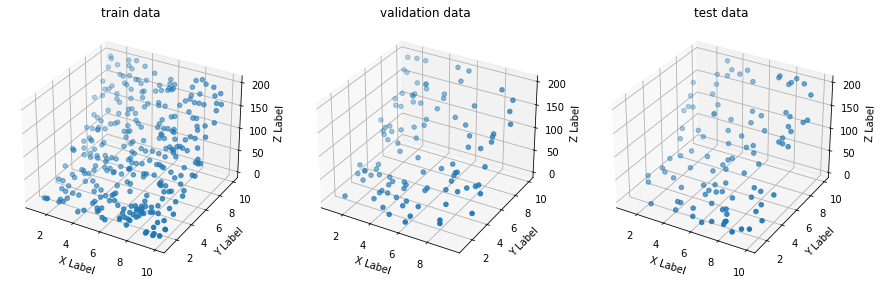

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(131, projection='3d')



xs = train_data[0,:]; ys = train_data[1,:]; zs = train_value
ax1.scatter(xs, ys, zs)
ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')
ax1.set_title('train data')

ax2 = fig.add_subplot(132, projection='3d')
for i in range(len(validation_data[0,:])):
    validation_value.append(f(validation_data[0,i], validation_data[1,i]))
xs = validation_data[0,:]; ys = validation_data[1,:]; zs = validation_value
ax2.scatter(xs, ys, zs)
ax2.set_xlabel('X Label')
ax2.set_ylabel('Y Label')
ax2.set_zlabel('Z Label')
ax2.set_title('validation data')

ax3 = fig.add_subplot(133, projection='3d')
for i in range(len(test_data[0,:])):
    test_value.append(f(test_data[0,i], test_data[1,i]))
xs = test_data[0,:]; ys = test_data[1,:]; zs = test_value
ax3.scatter(xs, ys, zs)
ax3.set_xlabel('X Label')
ax3.set_ylabel('Y Label')
ax3.set_zlabel('Z Label')
ax3.set_title('test data')

plt.show()

---
(b) 以類神經網路來訓練、測試及推估函數

In [13]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, Sequential
# Training Device
device = torch.device("cuda")

# Hyperparameters
BATCH_SIZE = 50
EPOCH = 3000

# Set up dataloader
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

# data length
train_data_size = len(train_data[0])
test_data_size = len(test_data[0])

# Define Neural Network
class NETWORK(nn.Module):
    def __init__(self):
        super(NETWORK, self).__init__()
        self.model1 = Sequential(
            nn.Linear(2,10),
            nn.ReLU(),
            nn.Linear(10,10),
            nn.ReLU(),
            nn.Linear(10,1)
        )
    def forward(self, x):
        x = self.model1(x)
        return x

network = NETWORK()
if torch.cuda.is_available():
    network = network.to(device)

# Set loss function
loss_fn = nn.MSELoss()
if torch.cuda.is_available():
    loss_fn = loss_fn.to(device)
learning_rate = 0.1

#optimizer = torch.optim.Adagrad(network.parameters(), lr=learning_rate)
optimizer = torch.optim.Adadelta(network.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=0.9)

# set parameters
total_train_step = 0
total_test_step = 0

train_data = Variable(torch.Tensor(train_data))
train_value = Variable(torch.Tensor(train_value))

for epoch in range(EPOCH):
    if epoch % 100 == 0:
        print(f"===EPOCH:{epoch}===")

    # set to training mode
    network.train()
    #print(len(train_data[1]))
    for i in range(len(train_data[1])):
        inputs = train_data[:,i]
        outputs = network(inputs)

        if torch.cuda.is_available():
            inputs = inputs.to(device)
            train_value[i] = train_value[i].to(device)

        #print(f'inputs = {inputs},\n outputs = {outputs},\n target = {train_value[i]}')
        loss = loss_fn(outputs, train_value[i])
        #print(f'loss={loss}')
        # something about optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_step = total_train_step + 1
        #if total_train_step % 50 == 0:
            # print("#training：{}, Loss: {}".format(total_train_step, loss.item()))
            # writer.add_scalar("train_loss", loss.item(), total_train_step)

    # set to test mode
    network.eval()
    total_test_loss = 0
    absone_total_accuracy = 0
    fiveper_total_accuracy = 0
    tenper_total_accuracy = 0

    with torch.no_grad():
        for i in range(len(test_data[0])):
            inputs = test_data[:,i]
            inputs = torch.Tensor(inputs)

            if torch.cuda.is_available():
                inputs = inputs.to(device)
                test_value[i] = test_value[i].to(device)

            outputs = network(inputs)
            loss = outputs - test_value[i]
            total_test_loss = total_test_loss + loss

            if abs(outputs - test_value[i]) < 1: absone_accuracy = 1
            else: absone_accuracy = 0
            absone_total_accuracy = absone_total_accuracy + absone_accuracy
            if abs(outputs - test_value[i]) < 0.05*test_value[i]: fiveper_accuracy = 1
            else: fiveper_accuracy = 0
            fiveper_total_accuracy = fiveper_total_accuracy + fiveper_accuracy
            if abs(outputs - test_value[i]) < 0.1*test_value[i]: tenper_accuracy = 1
            else: tenper_accuracy = 0
            tenper_total_accuracy = tenper_total_accuracy + tenper_accuracy
    if epoch % 100 == 0:
        print("Loss of test dataset: {}".format(total_test_loss))
        print(f"Overall accuracy of test dataset:")
        print(f"   +-1: {absone_total_accuracy/test_data_size} = {absone_total_accuracy}/{test_data_size}")
        print(f"   5% : {fiveper_total_accuracy/test_data_size} = {fiveper_total_accuracy}/{test_data_size}")
        print(f"   10%: {tenper_total_accuracy/test_data_size} = {tenper_total_accuracy}/{test_data_size}")
    total_test_step = total_test_step + 1

    #torch.save(tudui, "tudui_{}.pth".format(i))
    #print("模型已保存")

===EPOCH:0===
Loss of test dataset: tensor([-7570.6211])
Overall accuracy of test dataset:
   +-1: 0.05 = 5/100
   5% : 0.01 = 1/100
   10%: 0.01 = 1/100
===EPOCH:100===
Loss of test dataset: tensor([27.1164])
Overall accuracy of test dataset:
   +-1: 0.02 = 2/100
   5% : 0.1 = 10/100
   10%: 0.3 = 30/100
===EPOCH:200===
Loss of test dataset: tensor([-20.1403])
Overall accuracy of test dataset:
   +-1: 0.21 = 21/100
   5% : 0.29 = 29/100
   10%: 0.6 = 60/100
===EPOCH:300===
Loss of test dataset: tensor([-47.4300])
Overall accuracy of test dataset:
   +-1: 0.19 = 19/100
   5% : 0.48 = 48/100
   10%: 0.79 = 79/100
===EPOCH:400===
Loss of test dataset: tensor([-50.4189])
Overall accuracy of test dataset:
   +-1: 0.3 = 30/100
   5% : 0.54 = 54/100
   10%: 0.77 = 77/100
===EPOCH:500===
Loss of test dataset: tensor([-31.0562])
Overall accuracy of test dataset:
   +-1: 0.38 = 38/100
   5% : 0.69 = 69/100
   10%: 0.79 = 79/100
===EPOCH:600===
Loss of test dataset: tensor([-19.8700])
Overall ac

In [14]:
print(torch.cuda.is_available())
A = np.array([[1,2],[3,4]])
print(A[:,0])

False
[1 3]
